# ワランティデータおよび生産実績データの確認

## スズキ様のやりたいこと

### 目的(暫定):

- 予測系(平岡さんlead)
    - ある不具合が発生するトータルの件数を予測する。
        - ワランティと車両生産実績のデータを材料にして、翌月のワランティ発生数を予測する。

- 特徴抽出:数学的アプローチ(大西さんlead)
    - 不具合が起きた車両、不具合が起きてない車両それぞれのグループについてCANデータ他得られるすべての環境情報を用いて、クルマの使用方法の特徴（違い）を見つける。
    - 成分をクラスタ化・可視化して、物理的な意味づけをおこなう。
        - 車両が販売されてから、故障するまでの全データを用いる。
        - 想像もつかないような因子で不具合が発生することがあるので、物理的な意味を考えずに純粋に分類をおこない、あとから意味を考える。
- 特徴抽出:物理的アプローチ(外山さんlead)
    - CANデータ中のアクセル開度、車両の加減速度、ヨーレート等、物理的に意味がはっきりしている値を使って車の挙動を多次元で数値化し、運転状態のマッピングをおこなう。
    - 具体的な運転状態の分類・抽出をおこなう
        - 運転状態はあらかじめ定義をし、正確に数値で分類する。渋滞走行N％、急加速N回、急旋回の傾向N度、など。
        - また今後発生する要求に従い、特徴のある運転状態をCANデータの中から探せるようにする。
- 可視化(川瀬さんlead)
    - AWSの環境構築ができるようになる。サービスを使いこなす。
    - Webアプリケーション作成、データベース操作方法を習得する。
    - 自然言語処理の手法を習得する。
        - SIFTのテキストデータを分析してみる。

### 眞田の感想

- 予測系
    - 時間を明示的に扱うアプローチと、そうでないアプローチの2種類
        - 時間を明示的に扱うアプローチ(上から順に)
            1. 状態空間モデル
            2. リカレントニューラルネットワーク
            3. 生存分析
            4. 変化点検知
        - 時間を明示的に扱わないアプローチでは、リークのない変数の作り方やデータ分割の仕方を覚えると良いと思う
- 特徴抽出:数学的アプローチ
    - クラスタリング
    - 次元削減(上から順に)
        1. 主成分分析(カーネル主成分分析を含む)
        2. 多次元尺度法(ISOMAPを含む)
        3. オートエンコーダ（または[教師ありエンコーディング](https://arxiv.org/abs/1604.06737)）
        4. [t-SNE](https://www.slideshare.net/TakayukiYagi1/tsne)
- 特徴抽出:物理的アプローチ
- 可視化:

## ワランティデータと生産実績データについて

### データ内容

#### ワランティデータ

- 詳しく見たい項目:
    - 故障コード(条件,減少, 状況, 位置), 販売日, 故障日, FCOK日付, 車体番号, 生産機種記号, 主原因品番, 距離・時間, 費用合計
- 製品区分、走行距離、生産や販売からの期間、故障内容、故障状況、故障位置、作業内容、作業費用がわかる。

#### 生産実績データ

- 詳しく見たい項目:
    - 製品区分, 生産拠点コード, VIN, FCOK日付, 生産機種記号, 仕向地(仕様)など
- 製品区分、生産工場、搭載車体、生産日、出荷先が分かる。

#### 現在はないデータ

- 走行距離・時間については、故障した車についてしかわからない。
- 生産実績には販売日は含まれていない？（生産から何年たっても、販売から日が経っておらず使用されていない車両は故障しないだろう）
- 平均荷重
- 主要走行地域(販売地域を代用可能か)
- 温度データ

### 考えられる分析

#### モデルアプローチ

1. 生存分析
    - X:t(使用開始(販売)からの期間), パーツ種類, 車両種類, 平均走行距離, 販売後Xヶ月後フラグ(ノンパラ/セミパラメトリックであれば不要), 月フラグ, 生産から販売までの期間, (曜日フラグ, イベントフラグ(必要に応じて)
    - y:生存確率(生存関数)
2. 説明変数にtを含んだ、故障確率を予測する教師あり学習
    - 今回は故障したタイミングのみのデータセットなので1に近い。
    - 決定木などのモデルも使用できる。(生存分析でも決定木やディープラーニングを用いる方法もあるが・・・)
    - X:1と同じ
    - y:故障確率または生存確率
    - 陰性サンプルの平均走行距離はモデル等で補完するか、他のパーツが破損した車両のワランティデータを使用する。
3. 状態空間モデル
    - 上記2つは、(全データを用いると仮定して)基本的にはワランティ発生の性質は2000年でも2018年でも変わらない、ということを前提としている。
    - 近年は昔に比べて、気軽にワランティを発行する傾向が年々強まっている、のようなトレンドを考慮する場合は、状態空間モデルで陽に暦日をモデルに取り込む必要がある。(1または2のXに暦日を入れる方法もあるが)
    - 例えば、ポアソン分布のパラメータが時系列に応じて変化する、というようなモデルを仮定して、MCMC等の方法によってパラメータを推定する。
    - 上記が個別に
    - X:t(使用開始(販売)からの期間または暦日), パーツ種類, 車両種類, 平均走行距離, 販売後Xヶ月後フラグ, 月フラグ, 生産から販売までの期間, (曜日フラグ, イベントフラグ(必要に応じて)
    
#### 考えるポイント

- 個別に考えるか(ミクロ), 集計値で考えるか(マクロ)
    - 個人的には、ミクロで考える方が使える変数も多いため、良いと思う。
- "使用開始からの期間"という、おそらくは最も支配的であろう要因を、どのように取り込むか(暦日をtとした場合の状態空間モデルではこの点が難しい)
- 今回の分析で得られるスキルの応用可能性
    - この点では時系列分析が良いと思うが、この場合、"使用開始からの期間"を変数として取り込みづらい

#### モデリングプロセス

1. 受領データの確認
    - 分布確認
2. 受領データの加工
    - 外れ値の除去
    - 欠損値の処理
    - 特徴量の加工
3. 特徴量選択
    - $\chi^2$、正則化など
4. モデリング

#### 進め方案

- Teradataが2週間ほど先行して、部分的なデータ(一部のパーツなど)について分析を行う。
- 週に1回、分析に使用したnotebookを用いて、結果発表やスキルトランスファー、アフターフォローを行う。
- スズキ様はnotebookを参考にしながら、他のデータ(他のパーツなど)について分析を行う。

#### その他

- 各ワランティに対応する故障前のデータ（CANデータなど）があれば、より進んだ分析(故障予兆の分析)ができる

### データの確認

#### 生産データ

In [5]:
import pandas as pd

In [2]:
!head ../data/raw/tbhaa0006_fcok_20180401_20190330.csv

"V_BASE_CD","V_PROD_DIV","V_VIN","V_ENGINE_NO","V_MOTOR_NO","V_MISSON_NO","V_KEY_NO","V_FCOK","V_FCOK_TIME","V_ABOK","V_ABOK_TIME","V_PROD_MODEL_CD","V_SALES_MODEL_CD","V_SALES_MODEL_NM","V_SPEC","V_COLOR","V_PLANT_CD","V_DIST_CD","V_BRANCH_CD","V_SHIPPING_DATE","V_SHIPPING_FCOK","V_SHIPPING_ABOK","V_INVOICE_NO","V_SALES_NO","V_CASE_NO","V_SRC_DIV","V_CRT_TIME_STAMP"
"100100","B","MK53S-861193","R06A-B670795","","","L0590","20190315","125424","20190315","112157","","MK53S-ZTZP-JK","","000","ZVR","","403110","403080","20190313","","","","","","1",19-04-19 15:32:01.583547000
"100100","B","MK53S-861195","R06A-B671063","","","L4800","20190315","172154","20190315","162715","","MK53S-ZTZB-J","","000","DYA","","403110","403080","20190313","","","","","","1",19-04-19 15:32:01.587623000
"100100","B","MK53S-861196","R06A-B670870","","","L0124","20190315","142233","20190315","132702","","MK53S-ZTXB-JK","","000","ZVR","","502240","506070","20190313","","","","","","1",19-04-19 15:32:01.599814000
"

In [6]:
df_froc = pd.read_csv("../data/raw/tbhaa0006_fcok_20180401_20190330.csv")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,11,17,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
from IPython.display import display

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [7]:
display_all(df_froc.head())

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,MK53S-861193,R06A-B670795,NaN,NaN,L0590,20190315,125424.0,20190315.0,112157.0,NaN,MK53S-ZTZP-JK,NaN,000,ZVR,NaN,403110,403080.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.583547000
1,100100,B,MK53S-861195,R06A-B671063,NaN,NaN,L4800,20190315,172154.0,20190315.0,162715.0,NaN,MK53S-ZTZB-J,NaN,000,DYA,NaN,403110,403080.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.587623000
2,100100,B,MK53S-861196,R06A-B670870,NaN,NaN,L0124,20190315,142233.0,20190315.0,132702.0,NaN,MK53S-ZTXB-JK,NaN,000,ZVR,NaN,502240,506070.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.599814000
3,100100,B,MK53S-861197,R06A-B670799,NaN,NaN,L0635,20190315,125636.0,20190315.0,112613.0,NaN,MK53S-ZTZP-JK,NaN,000,ZVC,NaN,308010,308020.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.603856000
4,100100,B,MK53S-861198,R06A-B670875,NaN,NaN,L0134,20190315,143021.0,20190315.0,134140.0,NaN,MK53S-ZTZB-JK,NaN,000,ZVR,NaN,500020,500060.0,20190313.0,NaN,NaN,NaN,NaN,NaN,1,19-04-19 15:32:01.606902000


In [5]:
df_froc.shape

(1452670, 27)

In [6]:
import pandas_profiling as pdp

In [7]:
%matplotlib inline

In [83]:
pd_report_df_froc = pdp.ProfileReport(df_froc)
pd_report_df_froc.to_file("../reports/pd_report_tbhaa0006_fcok_20180401_20190330.html")

In [85]:
pd_report_df_froc

Number of variables,27
Number of observations,1452670
Total Missing (%),38.1%
Total size in memory,299.2 MiB
Average record size in memory,216.0 B
Numeric,7
Categorical,11
Boolean,0
Date,0
Text (Unique),2
Rejected,6


- V_KEY_NO, V_MISSION_NOは空白をnan(missing)に置き換える作業が必要か
- V_PROD_MODEL_CDは同様の項目がワランティデータにもあるが、生産データでは欠損が多い(半分程度)。V_SALES_MODEL_CDは欠損がほぼないが、ワランティデータには項目なし。
- V_SPEC(仕向地)は000が日本だとして、海外は欠損が多く、あまり追跡できていない

In [13]:
import gc
del df_froc
gc.collect()

669

#### ワランティデータ

In [8]:
df_proc = pd.read_csv("../data/raw/dbhaa0001_process_201501_201904.csv",
                     nrows = 500_000)

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,12,14,18,20,28,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
display_all(df_proc.head())

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100,1,B,0,201504,40223,JP,15C0100551,1,15.0,1,0,NaN,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99.0,76,24,9.0,NaN,NaN,NaN,910,0.2,1240,0,0,0,2150,3116,30,514,30,30,NaN,17-06-19 18:05:50.068344000
1,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,15.0,1,0,NaN,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99.0,65,24,1.0,NaN,NaN,NaN,910,0.2,1240,0,0,0,2150,3116,30,514,26,26,NaN,17-06-19 18:05:50.071115000
2,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,22.0,4,0,NaN,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99.0,85,29,4.0,NaN,NaN,NaN,878,0.2,1280,0,0,0,2158,3978,0,0,63,63,NaN,17-06-19 18:05:50.073222000
3,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,78.0,1,0,NaN,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32.0,85,23,8.0,NaN,NaN,NaN,878,0.2,1280,0,0,0,2158,3978,50,783,35,36,NaN,17-06-19 18:05:50.075672000
4,WRJPJP201504B001206,100100,100100,1,B,0,201504,50224,JP,15C0057741,1,6.0,4,0,NaN,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99.0,85,29,8.0,NaN,NaN,NaN,878,0.2,1280,0,0,0,2158,3978,0,0,59,60,NaN,17-06-19 18:05:50.077429000


In [16]:
df_proc.shape

(500000, 48)

In [33]:
pr_df_proc = pdp.ProfileReport(df_proc)

In [47]:
pr_df_proc.to_file("../reports/pd_report_dbhaa0001_process_201501_201904.html")

In [46]:
pr_df_proc

Number of variables,48
Number of observations,500000
Total Missing (%),12.9%
Total size in memory,183.1 MiB
Average record size in memory,384.0 B
Numeric,20
Categorical,15
Boolean,2
Date,0
Text (Unique),3
Rejected,8


- W_DIV1(保証区分1(GUALANTEE))はcleansingが必要(スペースが混入している？)
- W_DIV2(保証区分2(CLAIM))のコード2は何？その他？
- W_TROUBLE_MP(故障コード(位置))はカテゴリ型
- W_TROUBLE_CC(故障コード(条件))の99はその他っぽい。
- W_MILEAGE(距離・時間)は99999でカンストする
- W_LABOR_AMT(工賃)には大きな負の値がある。W_LABOR_HOURは常に0以上なので、外れ値？
- W_TOTAL_AMT(費用合計)はW_PARTS_AMT(部品代)と強い正の相関(0.9)がある。
- W_PROD_MODEL_CDが製品のコード、W_CAUSAL_PART_NOが主原因のパーツのコード。

##### 分布を見る

###### ワランティ発生までの月数

In [18]:
print(df_proc.W_SALES_TO_FAILURE.max())
print(df_proc.W_SALES_TO_FAILURE.min())

999

In [19]:
df_proc.W_SALES_TO_FAILURE.min()

0

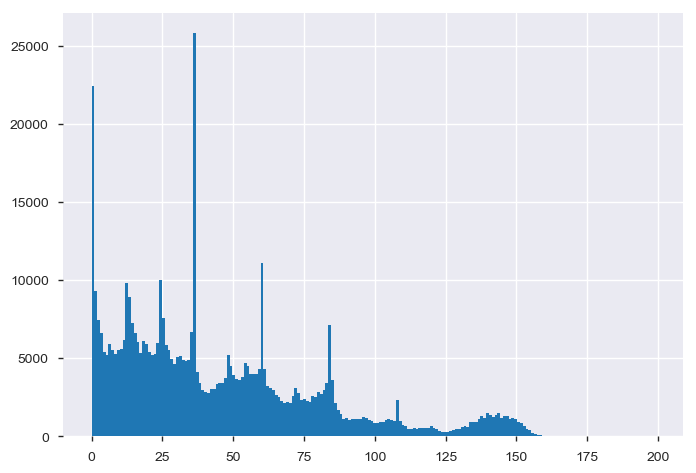

In [22]:
df_proc.W_SALES_TO_FAILURE[df_proc.W_SALES_TO_FAILURE<200].hist(bins=200)

- 36(3年), 0(直後), 60(5年後), 24(2年後), 12(1年後), 84(7年後)にピークがある
- 48(4年), 72(6年), 108(9年後)にも小さくピークがある
- 96(8年後)はピークは見えない
- 156(13年)を超えるとほぼなくなる。若干はあるが。
- 999(ミス？)が14件あった。

この時点で、恐らくはワイブル分布等のパラメトリックな生存分析は適用しにくいことがわかる。混合分布を考えるか、もしくはCox比例ハザード等のセミパラメトリックなモデルを適用する必要がある。

In [26]:
from IPython.display import display

def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [27]:
display_all(df_proc.W_SALES_TO_FAILURE
            .value_counts().sort_index()
            .to_frame().T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,208,209,212,213,215,216,217,218,219,222,224,226,229,231,232,234,235,236,237,239,240,241,242,244,245,246,247,265,266,268,285,323,999
W_SALES_TO_FAILURE,22441,9283,7431,6611,5402,5210,5915,5532,5300,5523,5574,6144,9823,8927,7263,6592,6018,5364,6093,5933,5415,5239,5282,5973,9989,7583,5843,5514,4925,4606,5088,5148,4870,4797,4910,6707,25800,4141,3438,2953,2819,2785,3037,3016,3368,3439,3416,3737,5205,4489,3939,3696,3623,3820,4679,4474,4016,3980,3978,4306,11124,4322,3252,3086,2967,2676,2537,2264,2160,2174,2136,2592,3091,2778,2353,2399,2264,2211,2559,2546,2827,2687,2960,3393,7125,3608,2112,1695,1409,1136,1170,1054,1099,1121,1126,1087,1241,1184,1063,959,868,836,907,950,1057,1104,1040,1016,2331,999,757,636,491,443,507,452,508,544,533,528,647,534,462,342,277,281,288,322,409,468,484,612,697,616,925,928,925,1132,1329,1156,1487,1367,1227,1395,1519,1165,1303,1299,1120,1155,1090,932,866,664,496,403,246,132,90,70,38,21,36,13,19,21,18,15,23,18,15,15,21,13,19,22,11,13,14,14,23,23,9,10,12,11,9,12,14,8,7,7,9,12,8,9,5,1,5,7,2,6,4,3,4,2,1,3,1,1,3,1,2,2,1,3,2,2,5,1,1,1,2,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,14


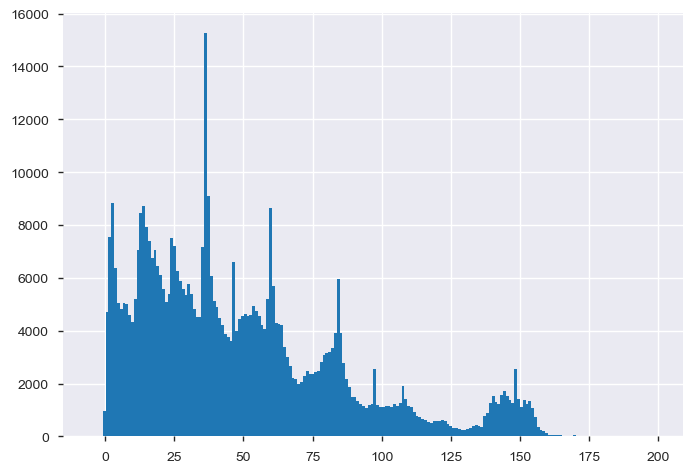

In [30]:
df_proc.W_FC_TO_FAILURE[df_proc.W_FC_TO_FAILURE<200].hist(bins=200)

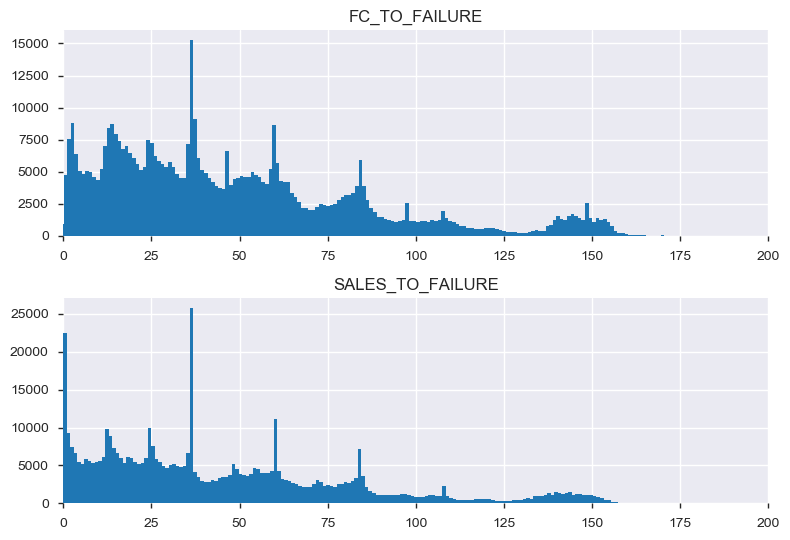

In [38]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
df_proc.W_FC_TO_FAILURE[df_proc.W_FC_TO_FAILURE<200].hist(bins=200)
plt.title("FC_TO_FAILURE")
plt.xlim(0, 200)
plt.subplot(2, 1, 2)
df_proc.W_SALES_TO_FAILURE[df_proc.W_SALES_TO_FAILURE<200].hist(bins=200)
plt.xlim(0, 200)
plt.title("SALES_TO_FAILURE")
plt.tight_layout()

(0, 200)

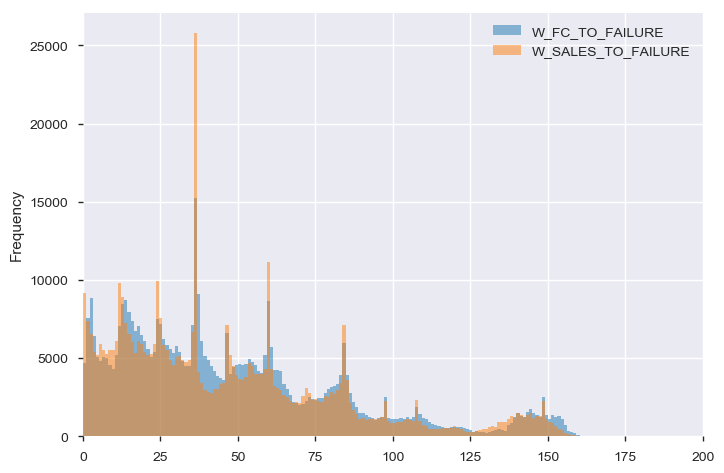

In [45]:
import numpy as np

T_TO_FAILURE_COLS = ["W_FC_TO_FAILURE","W_SALES_TO_FAILURE"]

df_proc.loc[np.logical_and(df_proc.W_FC_TO_FAILURE<200, df_proc.W_SALES_TO_FAILURE<200), 
            T_TO_FAILURE_COLS].plot.hist(bins=200, alpha=0.5)
plt.xlim(0,200)

- 当然だが、生産から販売まで期間があるので、W_FC_TO_FAILUREはW_SALES_TO_FAILUREを少し右に均したようなグラフとなっている
- 使用するであれば、W_SALES_TO_FAILUREを使うべき。

###### ワランティ発生月

Text(0.5, 1.0, 'W_PROCESS_MONTH')

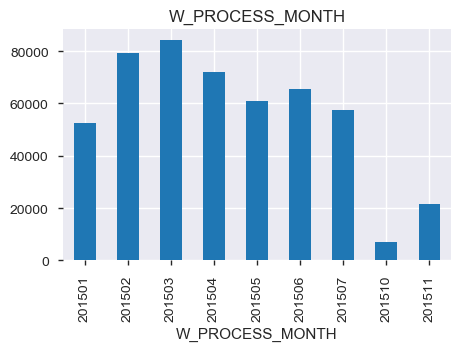

In [69]:
# カレンダー
# 処理日
df_proc.groupby("W_PROCESS_MONTH")["W_VIN"].apply(len).plot(kind="bar", figsize=(5,3))
plt.title("W_PROCESS_MONTH")

In [71]:
# 故障日
# extract month
df_proc = df_proc.assign(W_FAILURE_MONTH = (df_proc.W_FAILURE_DATE.astype("str").
                                            apply(lambda x: x[:6])).astype(int))
cnt_by_failure_month = df_proc.groupby("W_FAILURE_MONTH")["W_VIN"].apply(len)

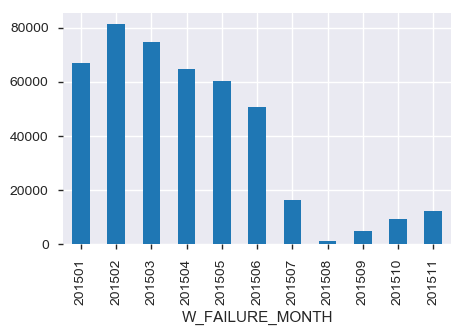

In [80]:
cnt_by_failure_month.loc[201501:].plot(kind="bar", figsize=(5,3))

夏が少ない?　全体の傾向を見る必要あり。

In [1]:
# 経過期間ではなく走行距離別のグラフをplot

In [81]:
# ToDo
# 1. 全体データで上記グラフ(カレンダー & 経過日プロット)を確認
# 2. パーツ毎 / 車体モデル毎 / 地域毎に分けて上記グラフを確認
# 3. 生産データを使用して、割合換算して上記グラフを確認
# 4. 生産データを使用して、パーツ毎 / 車体モデル毎 / 地域毎に分けて割合換算して上記グラフを確認